# Pedestrian classification
Erik Matovič and Jakub Horvat

[Dataset](https://data.nvision2.eecs.yorku.ca/PIE_dataset/)

### 0. Imports

In [127]:
import wandb
from pprint import pprint
import numpy as np
import pandas as pd
import torch 
from torch import flatten
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from utils import split_train_val
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, accuracy_score
from matplotlib import pyplot as plt
from os import listdir
from os.path import join
from pie_data import PIE
from PIL import Image
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(use_cuda, device)

True cuda:0


In [26]:
wandb.login()

api = wandb.Api()
sweep = api.sweep("xmatovice/uncategorized/1stel95e")

best_config = sweep.best_run().config
pprint(best_config)

wandb.init(config=best_config, project='uncategorized', name='NSIETE_zad1_final')
config = wandb.config

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Sorting runs by -summary_metrics.validation_accuracy


{'batch_size': 128,
 'dense1': 256,
 'epochs': 100,
 'learning_rate': 0.03648030109469176}


### 1. EDA
 - in [Exploratory Data Analysis](./EDA.ipynb)
 
### 2. Data preprocessing

In [2]:
#from pie_data import PIE

pie_path = '../' #'/media/erik/T7/DP/PIE_data' # <path_to_the_root_folder>
pie = PIE(data_path=pie_path)
type(pie)

pie_data.PIE

In [3]:
pie._images_path

'../images'

In [85]:
class PIE_dataset(Dataset):
    """
    Dataset class for dataloader.
    """
    def __init__(self, setname: str, pie: PIE) -> None:
        """
        Dataset init.
        :param setname: specifying trainig, validation or test set
        """
        assert setname in ['train', 'val', 'test'], 'wrong setname, accepting only \'train\', \'val\', \'test\''
        
        super().__init__()
        self.setname = setname
        self.img_path = pie._images_path + '/' + self.setname + '/'
        self.annotations_path = '../' + self.setname + '_annotations.csv'
        self.all_filenames = listdir(self.img_path)
        self.all_annotations = pd.read_csv(self.annotations_path)     
        self.all_annotations_meaning = self.all_annotations.columns.values.tolist()

        # Setting labels
        self.label_action = self.all_annotations['action']
        self.label_gesture = self.all_annotations['gesture']
        self.label_look = self.all_annotations['look']
        self.label_cross = self.all_annotations['cross']   
        
    
    def __len__(self) -> int:
        """
        Return the total number of images.
        returns: The total number of images.
        """
        return len(self.all_filenames)
    

    def __getitem__(self, index) -> dict:
        """
        Get item with annotations.
        :param index: the number of image
        returns: Dictionary.
        """
        file_name = self.all_filenames[index]
        img_path = self.img_path + file_name
        # Read the input image
        img = Image.open(img_path)#.convert('RGB')
        # convert image to torch tensor
        img_tensor = transforms.ToTensor()(img)
        # Transform to normalize the image with mean and std of the ImageNet dataset
        transform = transforms.Normalize(mean=(0.5,), std=(0.5,))
        normalized_img_tensor = transform(img_tensor)
        # convert the normalized tensor to PIL image
        # normalized_img = transforms.ToPILImage()(normalized_img_tensor)
        # normalized_img.show()

        # train
        set_idx_start = 16
        ped_index_start = 38
        
        # val
        if self.setname == 'val':
            set_idx_start = 14
            ped_index_start = 36

        # test
        if self.setname == 'test':
            set_idx_start = 15
            ped_index_start = 37

        # pedestrian index is varying from index 38 to 41
        ped_index = img_path.index('_', ped_index_start)

        set_name = img_path[set_idx_start:set_idx_start+5]
        video_name = img_path[set_idx_start+6:set_idx_start+16]
        ped_name = img_path[set_idx_start+17:ped_index]
        frame_name = img_path[ped_index + 1:]
        
        label = self.all_annotations.loc[
            (self.all_annotations.set == set_name) &
            (self.all_annotations.video == video_name) &
            (self.all_annotations.frame == frame_name) &
            (self.all_annotations.ped == ped_name)
        ]

        label_action = torch.tensor(self.label_action[label.index[0]], dtype=torch.long)
        label_gesture = torch.tensor(self.label_gesture[label.index[0]], dtype=torch.long)
        label_look = torch.tensor(self.label_look[label.index[0]], dtype=torch.long)
        label_cross = torch.tensor(self.label_cross[label.index[0]], dtype=torch.long)
        
        return {'data': normalized_img_tensor,
                'label_action': label_action,
                'label_gesture': label_gesture,
                'label_look': label_look,
                'label_cross': label_cross,
                'img_idx': index}

In [86]:
train_dataset = PIE_dataset('train', pie)
val_dataset = PIE_dataset('val', pie)
test_dataset = PIE_dataset('test', pie)

In [87]:
train_dataset.__getitem__(22)

{'data': tensor([[[-0.6314, -0.6314, -0.6392,  ..., -0.7961, -0.8039, -0.8039],
          [-0.6471, -0.6471, -0.6471,  ..., -0.7961, -0.8039, -0.8039],
          [-0.6549, -0.6549, -0.6549,  ..., -0.7961, -0.8039, -0.8039],
          ...,
          [-0.2235, -0.2235, -0.2314,  ..., -0.3098, -0.2941, -0.2941],
          [-0.2627, -0.2627, -0.2627,  ..., -0.1686, -0.1608, -0.1608],
          [-0.2784, -0.2784, -0.2784,  ..., -0.0196, -0.0118, -0.0118]]]),
 'label_action': tensor(0),
 'label_gesture': tensor(0),
 'label_look': tensor(0),
 'label_cross': tensor(0),
 'img_idx': 22}

In [88]:
train_dataset.all_filenames

['set04_video_0010_4_10_1476_00535.png',
 'set04_video_0013_4_13_1638_01748.png',
 'set04_video_0007_4_7_1285_00180.png',
 'set04_video_0011_4_11_1523_00622.png',
 'set04_video_0008_4_8_1371_01340.png',
 'set04_video_0008_4_8_1371_01339.png',
 'set02_video_0003_2_3_198_01172.png',
 'set04_video_0009_4_9_1421_04039.png',
 'set02_video_0003_2_3_198_01165.png',
 'set02_video_0003_2_3_197_01171.png',
 'set04_video_0009_4_9_1421_04041.png',
 'set01_video_0002_1_2_53_04698.png',
 'set04_video_0006_4_6_1232_02217.png',
 'set01_video_0001_1_1_1_01134.png',
 'set04_video_0008_4_8_1371_01336.png',
 'set02_video_0003_2_3_198_01166.png',
 'set04_video_0005_4_5_1206_04342.png',
 'set04_video_0011_4_11_1523_00626.png',
 'set04_video_0012_4_12_1543_00312.png',
 'set04_video_0004_4_4_1169_00282.png',
 'set04_video_0011_4_11_1524_00621.png',
 'set04_video_0006_4_6_1233_02229.png',
 'set04_video_0006_4_6_1232_02219.png',
 'set04_video_0011_4_11_1523_00625.png',
 'set04_video_0013_4_13_1637_01734.png',
 

In [89]:
train_dataset.all_annotations_meaning

['Unnamed: 0',
 'set',
 'video',
 'frame',
 'ped_idx',
 'ped',
 'BBox',
 'action',
 'gesture',
 'look',
 'cross']

In [90]:
len(train_dataset)

628

In [91]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) #, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) #, num_workers=4)

In [92]:
#type(train_dataloader)

Show images

(-0.5, 325.5, 325.5, -0.5)

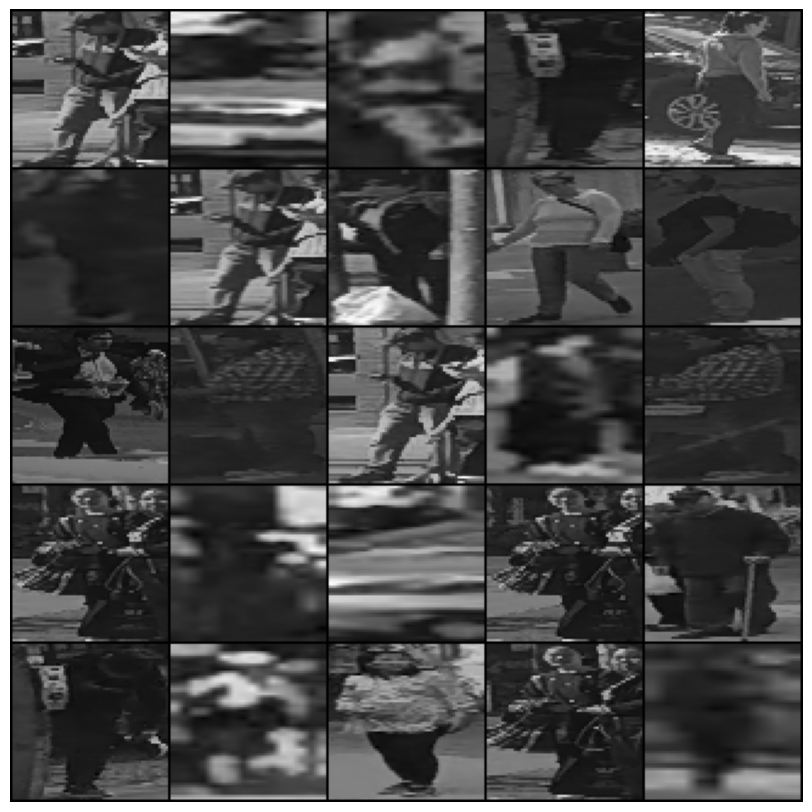

In [93]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)

#Plotting 25 images from the 1st batch 
dataiter = iter(train_dataloader)
sample = next(dataiter)

images, y_batch_action, y_batch_gesture, \
            y_batch_look, y_batch_cross, idx = sample['data'], sample['label_action'], \
                sample['label_gesture'], sample['label_look'], sample['label_cross'], \
                    sample['img_idx']

plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

## 3. Model

In [148]:
class CNN(nn.Module):
    """
    Model class
    """
    def __init__(self, n_channels) -> None:
        """
        init
        :param n_channels: number of input challens
        """
        super(CNN, self).__init__()
        # initialize first set of CONV => RELU => CONV => RELU => POOL layers
        self.conv11 = nn.Conv2d(in_channels=n_channels, out_channels=32, # 62 
                             kernel_size=(3, 3))
        #self.relu11 = nn.ReLU()
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=32, #60
			    kernel_size=(3, 3))
        #self.relu12 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #30

		# initialize second set of CONV => RELU => CONV => RELU => POOL layers
        self.conv21 = nn.Conv2d(in_channels=32, out_channels=64, #28
			kernel_size=(5, 5))
        #self.relu21 = nn.ReLU()
        self.conv22 = nn.Conv2d(in_channels=64, out_channels=64, #26
			kernel_size=(3, 3))
        #self.relu22 = nn.ReLU()
        # self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #13

        # MLP
        # initialize first set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=9216, out_features=5*128) #preco 9216?
        self.relu = nn.ReLU()

		# initialize second set of FC => RELU layers
        self.fc2 = nn.Linear(in_features=5*128, out_features=4*128)
        #self.relu3 = ReLU()

        self.fc_action = nn.Linear(512, 2)      # output action class
        self.fc_gesture = nn.Linear(512, 3)     # output gesture class
        self.fc_look = nn.Linear(512, 2)        # output look class
        self.fc_cross = nn.Linear(512, 2)       # output cross class

		# initialize our softmax classifier
        #self.fc3 = nn.Linear(in_features=5*128, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1) #dim=1 je ze to robi po riadkoch


    def forward(self, x) -> dict:        
        """
        forward pass
        :param x: data x
        """
        # pass the input through our first set of CONV => RELU =>
		# POOL layers
        output = self.conv11(x)
        output = self.relu(output)
        output = self.conv12(output)
        output = self.relu(output)
        output = self.maxpool(output)

		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
        output = self.conv21(output)
        output = self.relu(output)
        output = self.conv22(output)
        output = self.relu(output)
        output = self.maxpool(output)

		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
        output = flatten(output, 1)
		#print("after flatten ", output)
        output = self.fc1(output)
        output = self.relu(output)
		
        # pass the output to our softmax classifier to get our output
		# predictions
        output = self.fc2(output)
        output = self.relu(output)

        label_action = self.fc_action(output)
        label_gesture = self.fc_gesture(output) # torch.sigmoid(self.fc2(X))  
        label_look = self.fc_look(output)
        label_cross = self.fc_cross(output)

        label_action = self.logSoftmax(label_action)
        label_gesture = self.logSoftmax(label_gesture)
        label_look = self.logSoftmax(label_look)
        label_cross = self.logSoftmax(label_cross)
        
        # return 4 classes
        return {'label_action': label_action,
                'label_gesture': label_gesture,
                'label_look': label_look,
                'label_cross': label_cross}

In [149]:
# define training hyperparameters
INIT_LR = 1e-3
EPOCHS = 10

# initialize the LeNet model
print("[INFO] initializing the CNN model...")

model = CNN(
    n_channels=1 # 1 for grayscale
) 

model.to(device)

# initialize our optimizer and loss function
opt = optim.Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

[INFO] initializing the CNN model...


## 4. training & validation

In [150]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    return correct

In [151]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [152]:
def val_cnn(val_dl, loss_fn, model, device):
    """
    Validation
    """
    # init epoch validation counters
    epoch_train_accuracy_action, epoch_train_total_action, \
        epoch_train_true_action, epoch_train_loss = 0, 0, 0, 0
    
    epoch_train_accuracy_gesture, epoch_train_total_gesture, \
        epoch_train_true_gesture = 0, 0, 0
    
    epoch_train_accuracy_look, epoch_train_total_look, \
        epoch_train_true_look = 0, 0, 0
    
    epoch_train_accuracy_cross, epoch_train_total_cross, \
        epoch_train_true_cross = 0, 0, 0
    
    # disable gradient calculation
    with torch.no_grad():
        # enumerate mini batches
        for _, sample in enumerate(val_dl):
            # get X and y with index from sample
            X_batch, y_batch_action, y_batch_gesture, \
                y_batch_look, y_batch_cross, idx = sample['data'], sample['label_action'], \
                    sample['label_gesture'], sample['label_look'], sample['label_cross'], \
                        sample['img_idx']
            
            X_batch, y_batch_action, y_batch_gesture, y_batch_look, y_batch_cross = \
                X_batch.to(device), y_batch_action.to(device), y_batch_gesture.to(device), \
                    y_batch_look.to(device), y_batch_cross.to(device)
                     
            # compute the model output
            # Make prediction logits with model
            y_hat = model(X_batch)
            y_action = y_hat['label_action']
            y_gesture = y_hat['label_gesture']
            y_look = y_hat['label_look']
            y_cross = y_hat['label_cross']

            # Perform softmax calculation on logits across dimension 1 to get prediction probabilities
            #y_pred_probs = torch.softmax(y_logits, dim=1) 
            # go from logits -> prediction probabilities -> prediction labels
            #y_pred = torch.argmax(y_pred_probs, dim=1) 
            
            loss_action = loss_fn(y_action, y_batch_action)
            loss_gesture = loss_fn(y_gesture, y_batch_gesture)
            loss_look = loss_fn(y_look, y_batch_look)
            loss_cross = loss_fn(y_cross, y_batch_cross)

            loss = loss_action + loss_gesture + loss_look + loss_cross

            # update train counters
            epoch_train_loss += loss.item()

            epoch_train_true_action += accuracy_fn(torch.argmax(y_action, dim=1), y_batch_action)
            epoch_train_total_action += len(y_batch_action)

            epoch_train_true_gesture += accuracy_fn(torch.argmax(y_gesture, dim=1), y_batch_gesture)
            epoch_train_total_gesture += len(y_batch_gesture)

            epoch_train_true_look += accuracy_fn(torch.argmax(y_look, dim=1), y_batch_look)
            epoch_train_total_look += len(y_batch_look)

            epoch_train_true_cross += accuracy_fn(torch.argmax(y_cross, dim=1), y_batch_cross)
            epoch_train_total_cross += len(y_batch_cross)

        # update train accuracy & loss statistics
        epoch_train_loss /= (len(val_dl.dataset)/val_dl.batch_size)
        
        epoch_train_accuracy_action = (epoch_train_true_action/epoch_train_total_action) * 100
        epoch_train_accuracy_gesture = (epoch_train_true_gesture/epoch_train_total_gesture) * 100
        epoch_train_accuracy_look = (epoch_train_true_look/epoch_train_total_look) * 100
        epoch_train_accuracy_cross = (epoch_train_true_cross/epoch_train_total_cross) * 100

    return epoch_train_loss, epoch_train_accuracy_action, epoch_train_accuracy_gesture, \
        epoch_train_accuracy_look, epoch_train_accuracy_cross
    

In [172]:
def train_cnn(train_dl:DataLoader, val_dl:DataLoader, n_epochs:int, optimizer: optim, model: nn.Module, loss_fn: nn.NLLLoss, device):
    """
    Training
    """
    # init train lists for statistics
    loss_train, acc_action_train, acc_gesture_train, \
        acc_look_train, acc_cross_train = list(), list(), list(), list(), list()

    # init validation lists for statistics
    loss_val, acc_action_val, acc_gesture_val, \
        acc_look_val, acc_cross_val = list(), list(), list(), list(), list()
    
    early_stopper = EarlyStopper(patience=3, min_delta=10)    
    # enumerate epochs
    for epoch in range(n_epochs):
        # init epoch train counters
        epoch_train_accuracy_action, epoch_train_total_action, \
            epoch_train_true_action, epoch_train_loss = 0, 0, 0, 0
        
        epoch_train_accuracy_gesture, epoch_train_total_gesture, \
            epoch_train_true_gesture = 0, 0, 0
        
        epoch_train_accuracy_look, epoch_train_total_look, \
            epoch_train_true_look = 0, 0, 0
        
        epoch_train_accuracy_cross, epoch_train_total_cross, \
            epoch_train_true_cross = 0, 0, 0

        # enumerate mini batches
        for _, sample in enumerate(train_dl):
            # get X and y with index from sample
            X_batch, y_batch_action, y_batch_gesture, \
                y_batch_look, y_batch_cross, idx = sample['data'], sample['label_action'], \
                    sample['label_gesture'], sample['label_look'], sample['label_cross'], \
                        sample['img_idx']
            
            X_batch, y_batch_action, y_batch_gesture, y_batch_look, y_batch_cross = \
                X_batch.to(device), y_batch_action.to(device), y_batch_gesture.to(device), \
                    y_batch_look.to(device), y_batch_cross.to(device)
            
            # clear the gradients
            optimizer.zero_grad()
            
            # compute the model output
            # Make prediction logits with model
            y_hat = model(X_batch)
            y_action = y_hat['label_action']
            y_gesture = y_hat['label_gesture']
            y_look = y_hat['label_look']
            y_cross = y_hat['label_cross']

            # Perform softmax calculation on logits across dimension 1 to get prediction probabilities
            #y_pred_probs = torch.softmax(y_logits, dim=1) 
            # go from logits -> prediction probabilities -> prediction labels
            #y_pred = torch.argmax(y_pred_probs, dim=1) 
            
            loss_action = loss_fn(y_action, y_batch_action)
            loss_gesture = loss_fn(y_gesture, y_batch_gesture)
            loss_look = loss_fn(y_look, y_batch_look)
            loss_cross = loss_fn(y_cross, y_batch_cross)

            loss = loss_action + loss_gesture + loss_look + loss_cross

            # credit assignment
            loss.backward()
            
            # update model weights
            optimizer.step()

            # update train counters
            epoch_train_loss += loss.item()

            #print(y_action.shape)
            #print(y_batch_action.shape)

            epoch_train_true_action += accuracy_fn(torch.argmax(y_action, dim=1), y_batch_action)
            epoch_train_total_action += len(y_batch_action)

            epoch_train_true_gesture += accuracy_fn(torch.argmax(y_gesture, dim=1), y_batch_gesture)
            epoch_train_total_gesture += len(y_batch_gesture)

            epoch_train_true_look += accuracy_fn(torch.argmax(y_look, dim=1), y_batch_look)
            epoch_train_total_look += len(y_batch_look)

            epoch_train_true_cross += accuracy_fn(torch.argmax(y_cross, dim=1), y_batch_cross)
            epoch_train_total_cross += len(y_batch_cross)

        # update train accuracy & loss statistics
        epoch_train_loss /= (len(train_dl.dataset)/train_dl.batch_size)
        
        epoch_train_accuracy_action = (epoch_train_true_action/epoch_train_total_action) * 100
        epoch_train_accuracy_gesture = (epoch_train_true_gesture/epoch_train_total_gesture) * 100
        epoch_train_accuracy_look = (epoch_train_true_look/epoch_train_total_look) * 100
        epoch_train_accuracy_cross = (epoch_train_true_cross/epoch_train_total_cross) * 100
        
        # validation
        epoch_val_loss, epoch_val_acc_action, epoch_val_acc_gesture, \
            epoch_val_acc_look, epoch_val_acc_cross = val_cnn(val_dl=val_dl, 
                                                              model=model, 
                                                              loss_fn=loss_fn, 
                                                              device=device)
        
        # update global train stats
        loss_train.append(epoch_train_loss)
        acc_action_train.append(epoch_train_accuracy_action)
        acc_gesture_train.append(epoch_train_accuracy_gesture)
        acc_look_train.append(epoch_train_accuracy_look)
        acc_cross_train.append(epoch_train_accuracy_cross)

        # update global validation stats
        loss_val.append(epoch_val_loss)
        acc_action_val.append(epoch_val_acc_action) 
        acc_gesture_val.append(epoch_val_acc_gesture)
        acc_look_val.append(epoch_val_acc_look)
        acc_cross_val.append(epoch_val_acc_cross)

        # print
        if epoch % 2 == 0: #== (n_epochs - 1):
            print(
                f'Epoch {epoch}/{n_epochs}: \
                train loss {loss_train[-1]}, \
                val loss {loss_val[-1]}, \
                action train acc {acc_action_train[-1]}, \
                gesture train acc {acc_gesture_train[-1]}, \
                look train acc {acc_look_train[-1]}, \
                cross train acc {acc_cross_train[-1]}, \
                action val acc {acc_action_val[-1]}, \
                gesture val acc {acc_gesture_val[-1]}, \
                look val acc {acc_look_val[-1]}, \
                cross val acc {acc_cross_val[-1]}'
            )

        # early stopping
        if early_stopper.early_stop(epoch_val_loss):    
            print(f'Early stopped at {epoch}')         
            break
        
    return loss_train, acc_action_train, acc_gesture_train, acc_look_train, \
        acc_cross_train, loss_val, acc_action_val, acc_gesture_val, \
            acc_look_val, acc_cross_val

In [173]:
loss_train, acc_action_train, acc_gesture_train, acc_look_train, \
        acc_cross_train, loss_val, acc_action_val, acc_gesture_val, \
            acc_look_val, acc_cross_val = \
                train_cnn(
    n_epochs=EPOCHS,
    model=model,
    optimizer=opt,
    loss_fn=lossFn,
    train_dl=train_dataloader,
    val_dl=val_dataloader,
    device=device
    )

Epoch 0/10:                 train loss 0.02256334098471198,                 val loss 7.066191482543945,                 action train acc 100.0,                 gesture train acc 100.0,                 look train acc 99.36305732484077,                 cross train acc 100.0,                 action val acc 56.25,                 gesture val acc 100.0,                 look val acc 72.91666666666666,                 cross val acc 99.58333333333333
Epoch 2/10:                 train loss 0.05162867656938589,                 val loss 8.74507433573405,                 action train acc 100.0,                 gesture train acc 100.0,                 look train acc 99.36305732484077,                 cross train acc 100.0,                 action val acc 54.58333333333333,                 gesture val acc 100.0,                 look val acc 55.00000000000001,                 cross val acc 100.0
Epoch 4/10:                 train loss 0.030437495535726,                 val loss 6.442108027140299,      

In [174]:
def evaluation(model, test_dl):
    """
    evaluation
    """    
    y_test_all_action, y_test_all_gesture, y_test_all_cross, y_test_all_look = list(), list(), list(), list()
    y_all_action, y_all_gesture, y_all_cross, y_all_look = list(), list(), list(), list()
    # total_action, total_gesture, total_cross, total_look = 0, 0, 0, 0
    correct_action, correct_gesture, correct_cross, correct_look = 0, 0, 0, 0
    # disable gradient calculation
    with torch.no_grad():
        # enumerate mini batches
        for _, sample in enumerate(test_dl):
            # get X and y with index from sample
            X_batch, y_batch_action, y_batch_gesture, \
                y_batch_look, y_batch_cross, idx = sample['data'], sample['label_action'], \
                    sample['label_gesture'], sample['label_look'], sample['label_cross'], \
                        sample['img_idx']
            
            X_batch, y_batch_action, y_batch_gesture, y_batch_look, y_batch_cross = \
                X_batch.to(device), y_batch_action.to(device), y_batch_gesture.to(device), \
                    y_batch_look.to(device), y_batch_cross.to(device)
                     
            # compute the model output
            # Make prediction logits with model
            y_hat = model(X_batch)
            y_action = y_hat['label_action']
            y_gesture = y_hat['label_gesture']
            y_look = y_hat['label_look']
            y_cross = y_hat['label_cross']

            true_action_max = torch.argmax(y_action, dim=1)
            true_gesture_max = torch.argmax(y_gesture, dim=1)
            true_look_max = torch.argmax(y_look, dim=1)
            true_cross_max = torch.argmax(y_cross, dim=1)

            # accuracies
            true_action = accuracy_fn(true_action_max, y_batch_action)
            true_gesture = accuracy_fn(true_gesture_max, y_batch_gesture)
            true_look = accuracy_fn(true_look_max, y_batch_look)
            true_cross = accuracy_fn(true_cross_max, y_batch_cross)
        
            # update predictions stats
            y_all_action.extend(true_action_max.cpu().numpy())
            y_all_gesture.extend(true_gesture_max.cpu().numpy())
            y_all_look.extend(true_look_max.cpu().numpy())
            y_all_cross.extend(true_cross_max.cpu().numpy())

            # update batch y stats
            y_test_all_action.extend(y_batch_action.cpu().numpy())
            y_test_all_gesture.extend(y_batch_gesture.cpu().numpy())
            y_test_all_look.extend(y_batch_look.cpu().numpy())
            y_test_all_cross.extend(y_batch_cross.cpu().numpy())

            correct_action += true_action
            correct_gesture += true_gesture
            correct_look += true_look
            correct_cross += true_cross
            
            #print('action acc: %.3f' % ((true_action / test_dl.batch_size) * 100))
            #print('gesture acc: %.3f' % ((true_gesture / test_dl.batch_size) * 100))
            #print('look acc: %.3f' % ((true_look / test_dl.batch_size) * 100))
            #print('cross acc: %.3f' % ((true_cross / test_dl.batch_size) * 100))

    #print(y_test_all_action)
    #print(y_all_action)
    report_action = classification_report(y_test_all_action, y_all_action, target_names=['0', '1'])
    report_gesture = classification_report(y_test_all_gesture, y_all_gesture, target_names=['0'])#, '1', '2'])
    report_look = classification_report(y_test_all_look, y_all_look, target_names=['0', '1'])
    report_cross = classification_report(y_test_all_cross, y_all_cross, target_names=['0', '1', '2'])
    

    matrix_action = confusion_matrix(y_test_all_action, y_all_action)
    matrix_gesture = confusion_matrix(y_test_all_gesture, y_all_gesture)
    matrix_look = confusion_matrix(y_test_all_look, y_all_look)
    matrix_cross = confusion_matrix(y_test_all_cross, y_all_cross)
    
    matrix_action_display = ConfusionMatrixDisplay(matrix_action, display_labels=['0', '1'])
    matrix_gesture_display = ConfusionMatrixDisplay(matrix_gesture, display_labels=['0'])
    matrix_look_display = ConfusionMatrixDisplay(matrix_look, display_labels=['0', '1'])
    matrix_cross_display = ConfusionMatrixDisplay(matrix_cross, display_labels=['0', '1', '2'])

    return report_action, report_gesture, report_look, report_cross, \
        matrix_action_display, matrix_gesture_display, \
            matrix_look_display, matrix_cross_display
    

In [175]:
report_action, report_gesture, report_look, report_cross, \
        matrix_action_display, matrix_gesture_display, \
            matrix_look_display, matrix_cross_display = evaluation(model, test_dataloader)

In [176]:
print('ACTION\n')
pprint(report_action)

print('\nGESTURE\n')
pprint(report_gesture)

ACTION

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.47      0.70      0.56       331\n'
 '           1       0.37      0.18      0.25       320\n'
 '\n'
 '    accuracy                           0.45       651\n'
 '   macro avg       0.42      0.44      0.40       651\n'
 'weighted avg       0.42      0.45      0.41       651\n')

GESTURE

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      1.00      1.00       651\n'
 '\n'
 '    accuracy                           1.00       651\n'
 '   macro avg       1.00      1.00      1.00       651\n'
 'weighted avg       1.00      1.00      1.00       651\n')


In [177]:
print('\nLOOK\n')
pprint(report_look)

print('\nCROSS\n')
pprint(report_cross)


LOOK

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.91      0.77      0.83       603\n'
 '           1       0.02      0.06      0.03        48\n'
 '\n'
 '    accuracy                           0.71       651\n'
 '   macro avg       0.47      0.41      0.43       651\n'
 'weighted avg       0.85      0.71      0.77       651\n')

CROSS

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.00      0.00      0.00        16\n'
 '           1       0.89      1.00      0.94       577\n'
 '           2       0.00      0.00      0.00        58\n'
 '\n'
 '    accuracy                           0.89       651\n'
 '   macro avg       0.30      0.33      0.31       651\n'
 'weighted avg       0.79      0.89      0.83       651\n')


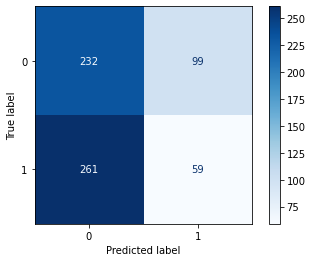

In [178]:
matrix_action_display.plot(cmap='Blues')

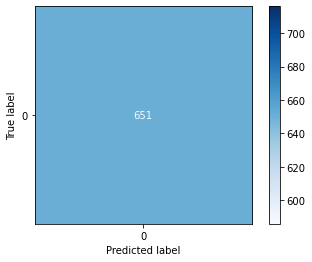

In [179]:
matrix_gesture_display.plot(cmap='Blues')

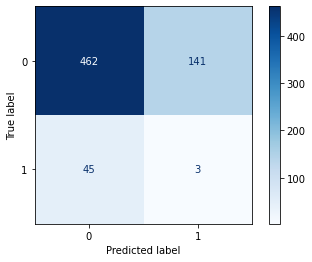

In [180]:
matrix_look_display.plot(cmap='Blues')

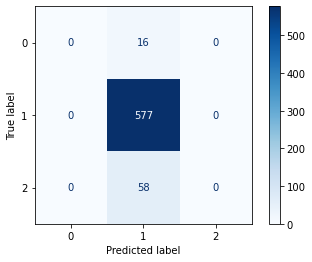

In [181]:
matrix_cross_display.plot(cmap='Blues')

In [182]:
# measure how long training is going to take
#print("[INFO] training the network...")
#startTime = time.time()

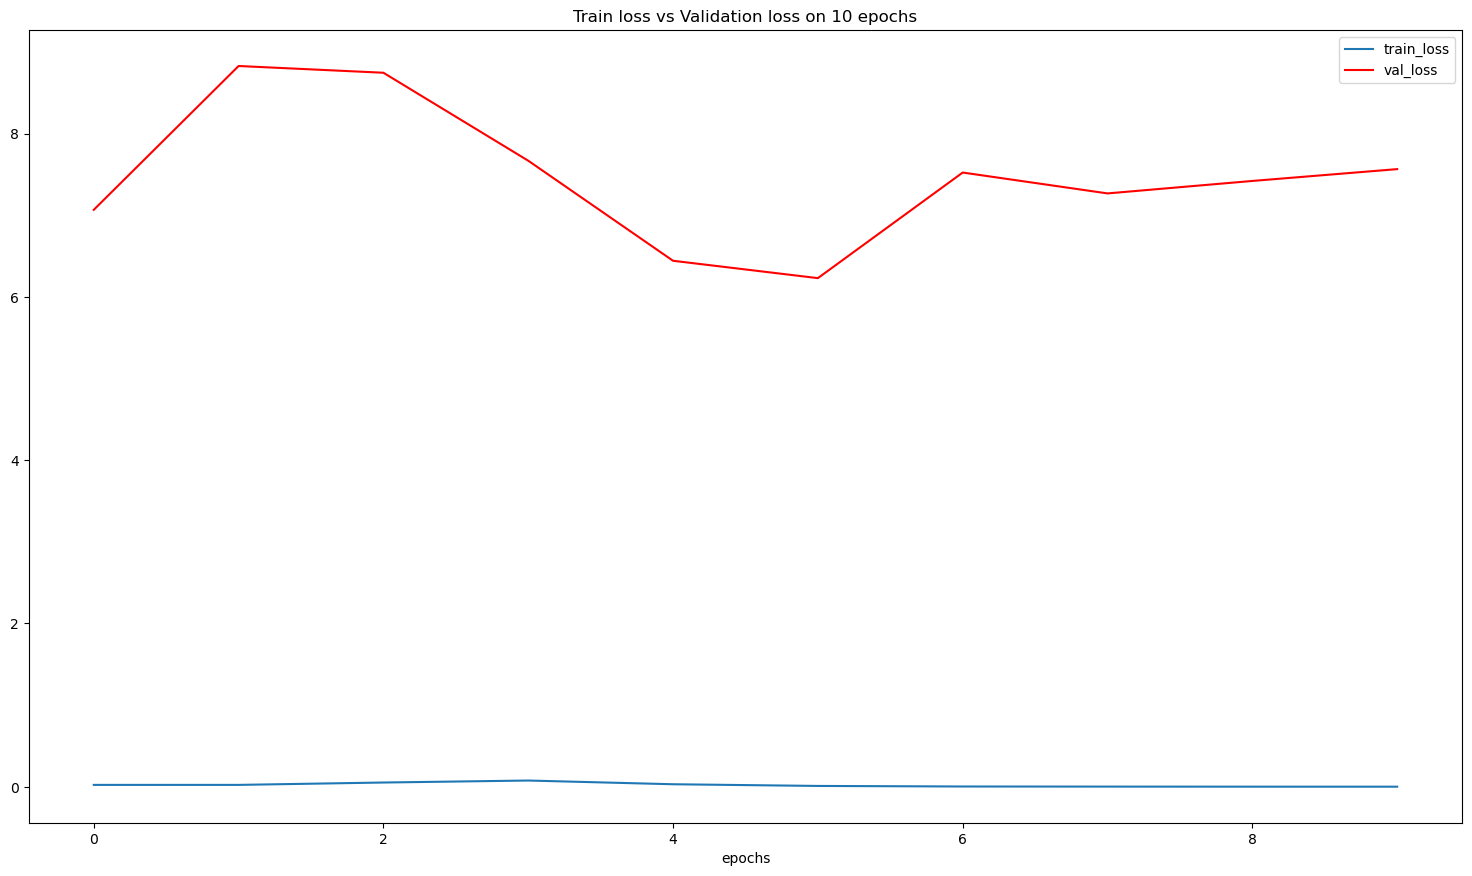

In [190]:
def plot_loss(train_loss, val_loss):
    '''
    Visualize training loss vs. validation loss.
    Parameters
    ----------
    train_loss: training loss
    val_loss: validation loss
    Returns: None
    -------
    '''
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    loss_csv = pd.DataFrame({"epochs": range(len(train_loss)), "train_loss": train_loss,
                             "val_loss": val_loss})
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    loss_csv.plot(kind='line',x='epochs',y='train_loss',ax=ax )
    loss_csv.plot(kind='line',x='epochs',y='val_loss', color='red', ax=ax)
    plt.title(f'Train loss vs Validation loss on {len(train_loss)} epochs')
    #plt.ylim([0, 3])
    plt.show()
    # plt.savefig("../outputs/train_vs_val_loss.png")

# Examine results
plot_loss(loss_train, loss_val)

In [184]:
def plot_accuracy(train_accuracy, validation_accuracy):
    """
    TODO: refactor
    """
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    accuracy_csv = pd.DataFrame({
        "epochs": range(len(train_accuracy)), 
        "train_accuracy": train_accuracy,
        "validation_accuracy": validation_accuracy
    })
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    accuracy_csv.plot(kind='line',x='epochs',y='train_accuracy', ax=ax)
    accuracy_csv.plot(kind='line',x='epochs',y='validation_accuracy', color='red', ax=ax)
    plt.title(f'Train accuracy vs Validation accuracy on {len(train_accuracy)} epochs')
    plt.show()

#print(accuracy_train, accuracy_validation)

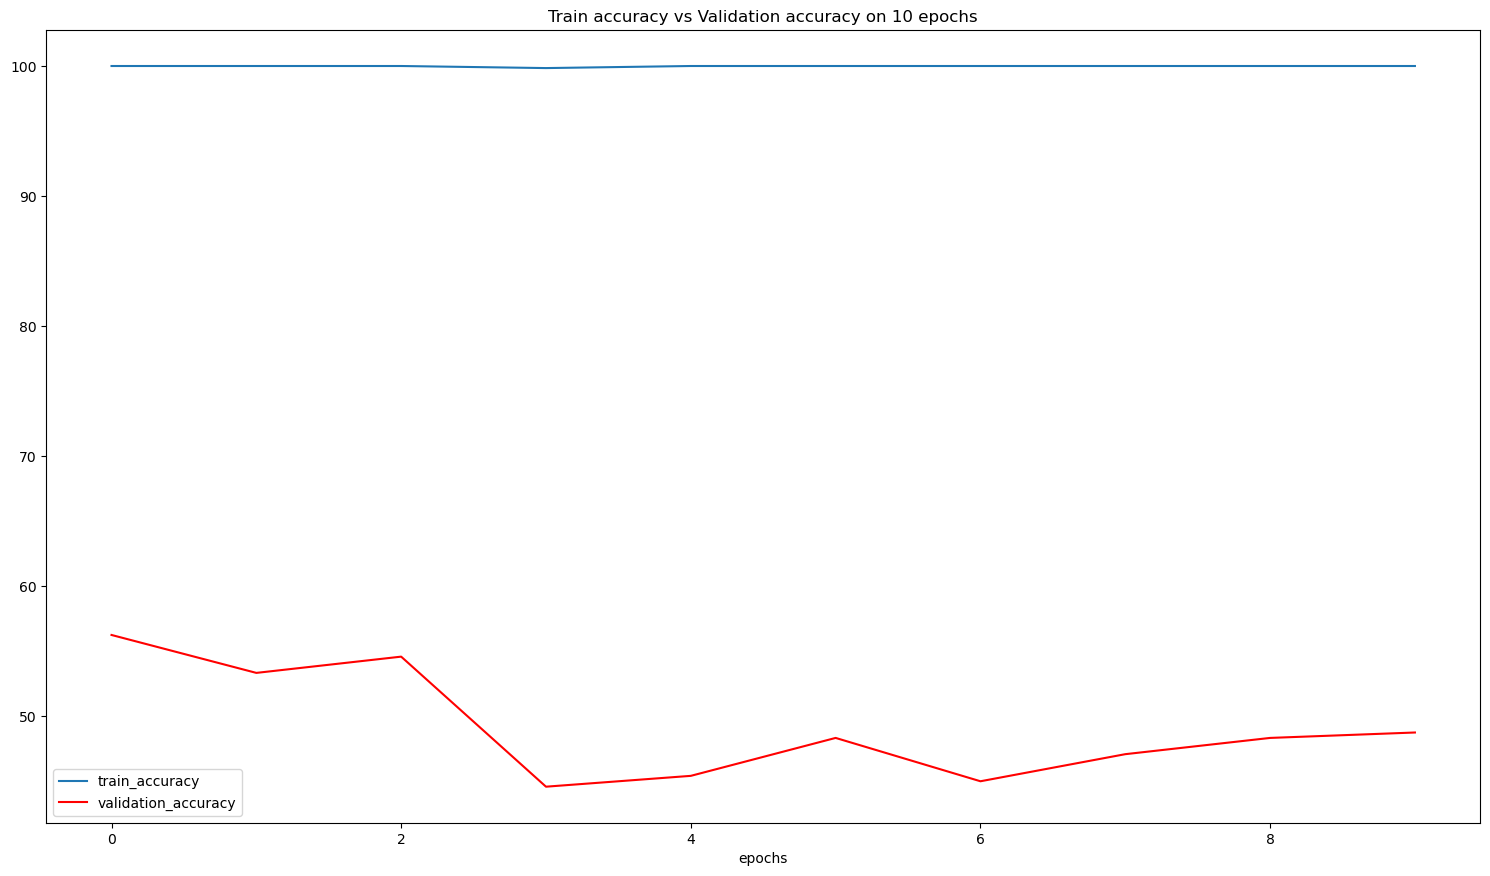

In [185]:
plot_accuracy(acc_action_train, acc_action_val)

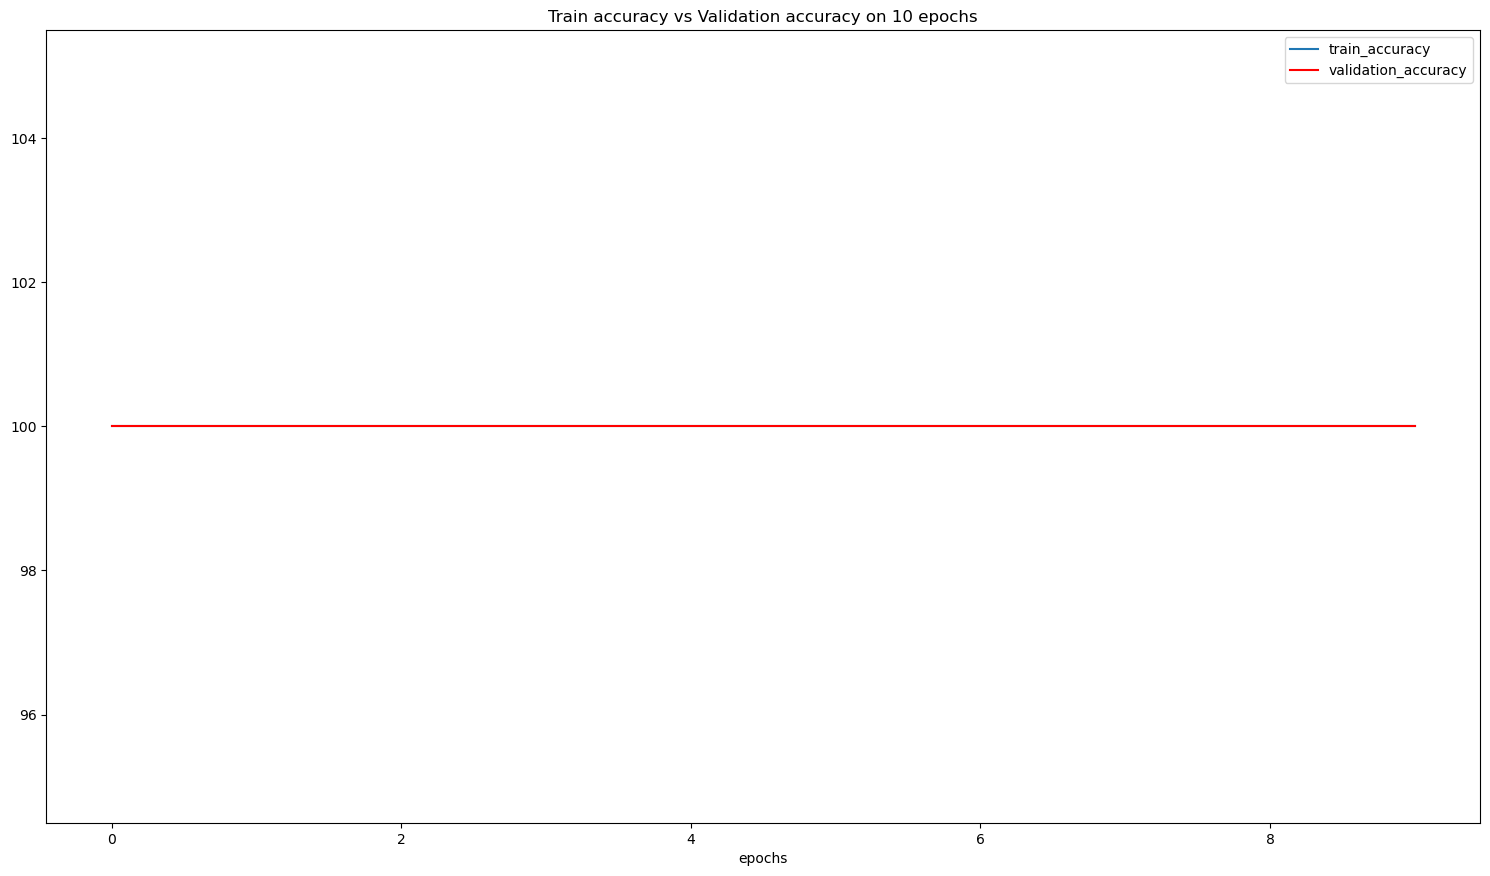

In [186]:
plot_accuracy(acc_gesture_train, acc_gesture_val)

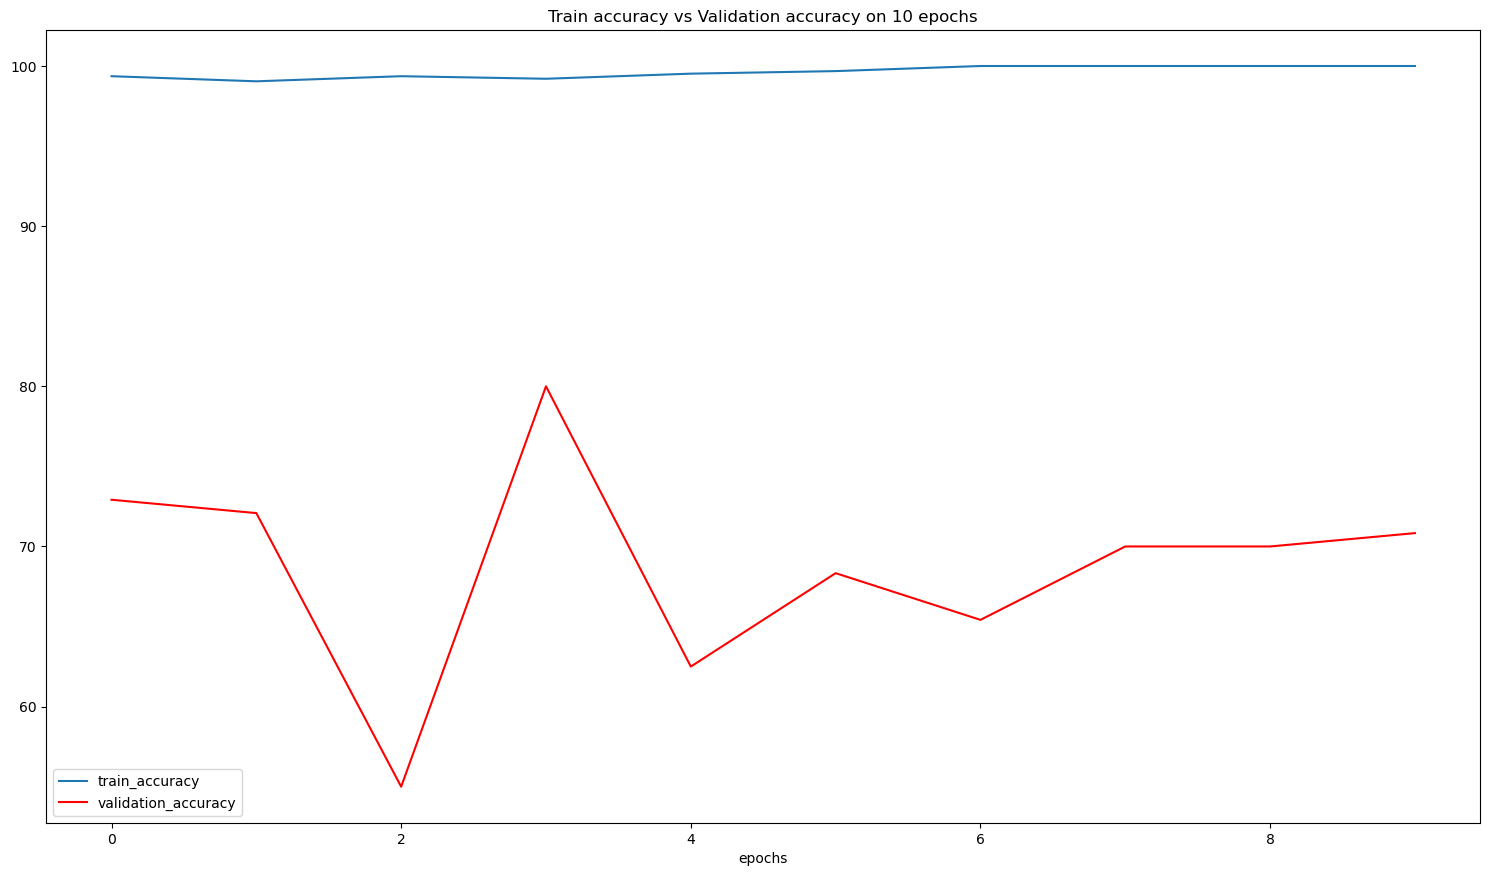

In [187]:
plot_accuracy(acc_look_train, acc_look_val)

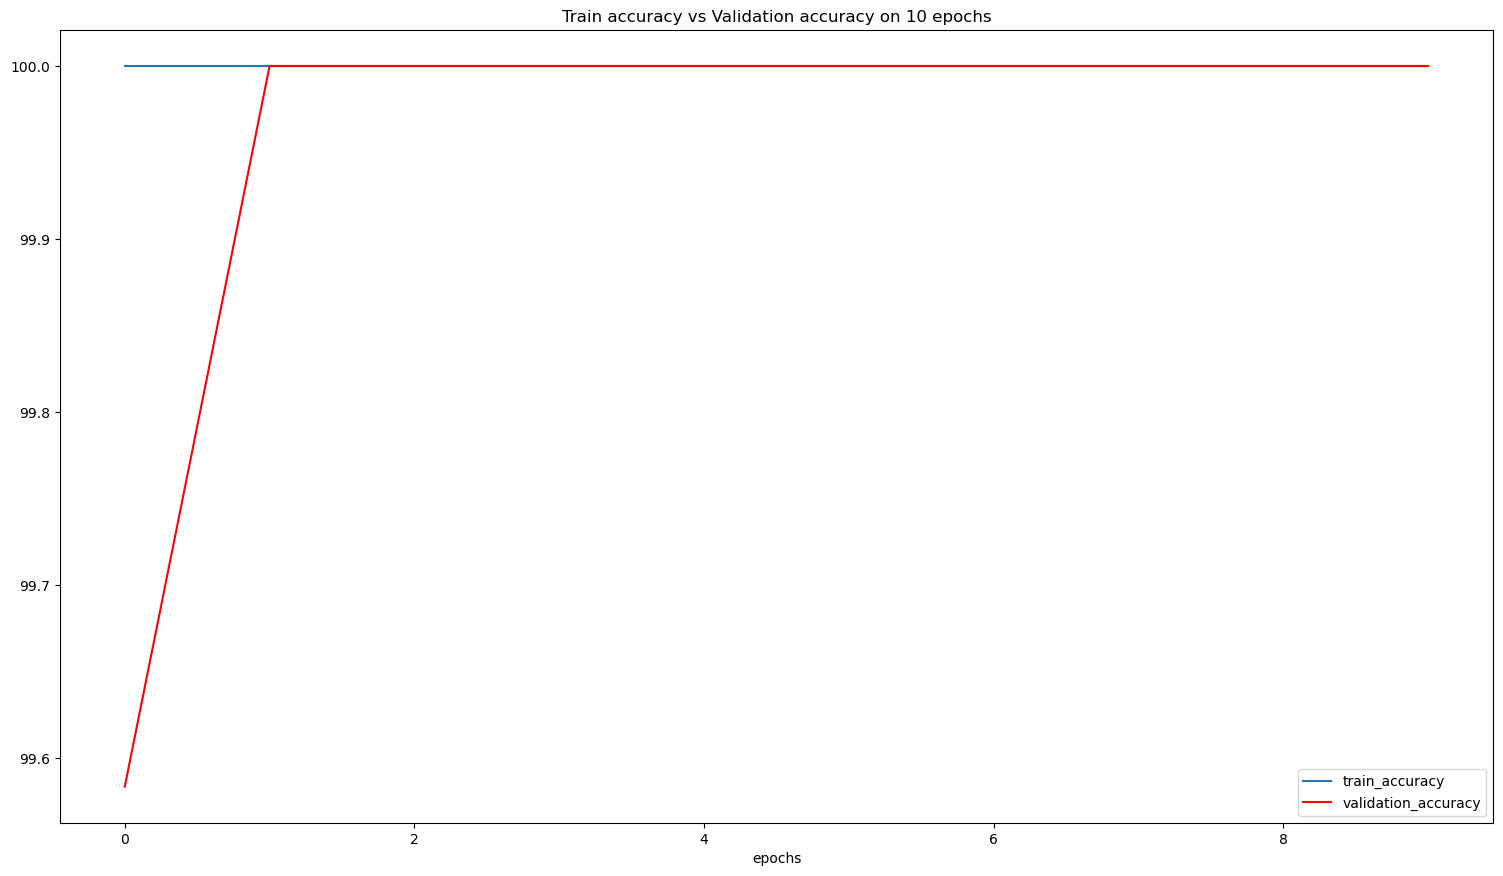

In [188]:
plot_accuracy(acc_cross_train, acc_cross_val)